In [17]:
from datetime import datetime
import os
import re

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from ipynb.fs.defs.functions import prep_data, train, break_out_solution
from models.multi_head.model import Model as MultiHeadModel

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [18]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [19]:
# Load images and labels
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [20]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [21]:
# Create train, test, and validation sets
train_dataset, test_dataset, val_dataset = prep_data(data)

In [22]:
print(
    f"Training input shape: {train_dataset.tensors[0].shape}\nTraining output shape: {train_dataset.tensors[1].shape}"
)

Training input shape: torch.Size([4000, 3, 64, 64])
Training output shape: torch.Size([4000, 37])


## Training

In [23]:
# Instantiate the model
model = MultiHeadModel(DEVICE).to(DEVICE)

In [24]:
# Training Parameters
EPOCHS = 200
BATCH_SIZE = 64
LR = 0.01
GAMMA = 0.99

# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Save path
model_name = "relu"
save_path = (
    "models/"
    + re.sub(r"(?<!^)(?=[A-Z])", "_", model.__class__.__name__).lower()
    + "/"
    + optimizer.__class__.__name__
    + "/"
    + criterion.__class__.__name__
    + "/"
)

In [25]:
# Run a single image through the model
model_output = model(train_dataset.tensors[0][0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 37])


In [26]:
# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

11/22 19:20:36 Train Epoch:    1 [4000/4000 (100%)]	Train Loss: 17.757146	Test Loss: 17.393275
11/22 19:20:37 Train Epoch:    2 [4000/4000 (100%)]	Train Loss: 17.519698	Test Loss: 17.299938
11/22 19:20:37 Train Epoch:    3 [4000/4000 (100%)]	Train Loss: 17.472807	Test Loss: 17.270537
11/22 19:20:38 Train Epoch:    4 [4000/4000 (100%)]	Train Loss: 17.454421	Test Loss: 17.254436
11/22 19:20:39 Train Epoch:    5 [4000/4000 (100%)]	Train Loss: 17.424737	Test Loss: 17.246673
11/22 19:20:40 Train Epoch:    6 [4000/4000 (100%)]	Train Loss: 17.426188	Test Loss: 17.240418
11/22 19:20:40 Train Epoch:    7 [4000/4000 (100%)]	Train Loss: 17.435290	Test Loss: 17.233443
11/22 19:20:41 Train Epoch:    8 [4000/4000 (100%)]	Train Loss: 17.425462	Test Loss: 17.224001
11/22 19:20:42 Train Epoch:    9 [4000/4000 (100%)]	Train Loss: 17.409070	Test Loss: 17.219904
11/22 19:20:43 Train Epoch:   10 [4000/4000 (100%)]	Train Loss: 17.369361	Test Loss: 17.244335
11/22 19:20:43 Train Epoch:   11 [4000/4000 (100%)

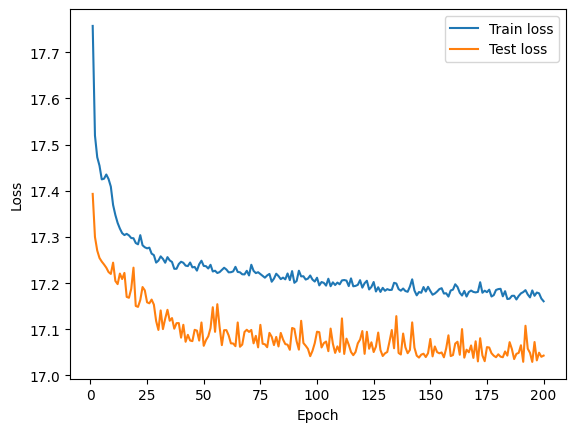

In [28]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

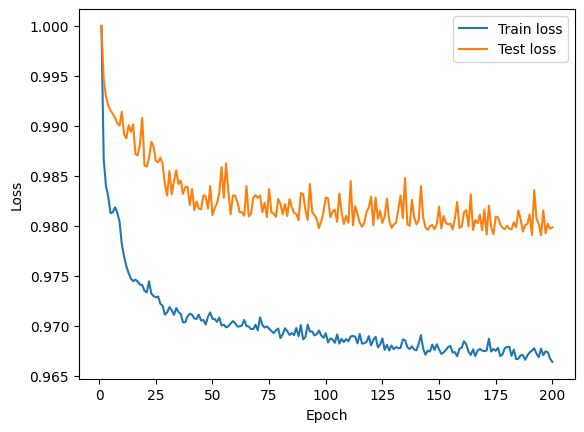

In [29]:
# Plot normalized losses
plt.plot(range(1, EPOCHS + 1), np.array(train_loss) / np.max(train_loss), label="Train loss")
plt.plot(range(1, EPOCHS + 1), np.array(test_loss) / np.max(test_loss), label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation

In [30]:
# Evaluation Metrics
model.eval()

# Eval Size
eval_size = 1000

true_labels = break_out_solution(test_dataset.tensors[1][:eval_size])
pred_labels = break_out_solution(model(test_dataset.tensors[0][:eval_size]))

# Calculate evaluation metrics
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    print(f"Accuracy: {accuracy_score(true_labels[i], pred_labels[i])}")
    print(f"Precision: {precision_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"Recall: {recall_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"F1 Score: {f1_score(true_labels[i], pred_labels[i], average='macro')}")
    print()

Class 1:
Accuracy: 0.542
Precision: 0.18066666666666667
Recall: 0.3333333333333333
F1 Score: 0.2343277129269347

Class 2:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class 3:
Accuracy: 0.826
Precision: 0.413
Recall: 0.5
F1 Score: 0.452354874041621

Class 4:
Accuracy: 0.9
Precision: 0.45
Recall: 0.5
F1 Score: 0.47368421052631576

Class 5:
Accuracy: 0.428
Precision: 0.21755750957789743
Recall: 0.37447094557586014
F1 Score: 0.27340798885525225

Class 6:
Accuracy: 0.964
Precision: 0.48490945674044267
Recall: 0.49690721649484537
F1 Score: 0.4908350305498982

Class 7:
Accuracy: 0.706
Precision: 0.23627844712182064
Recall: 0.3333333333333333
F1 Score: 0.2765374069721896

Class 8:
Accuracy: 0.216
Precision: 0.030857142857142857
Recall: 0.14285714285714285
F1 Score: 0.05075187969924812

Class 9:
Accuracy: 0.372
Precision: 0.27446648310277927
Recall: 0.47534246575342465
F1 Score: 0.31988089175189144

Class 10:
Accuracy: 0.862
Precision: 0.28733333333333333
Recall: 0.3333333333333333


c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Class 1:


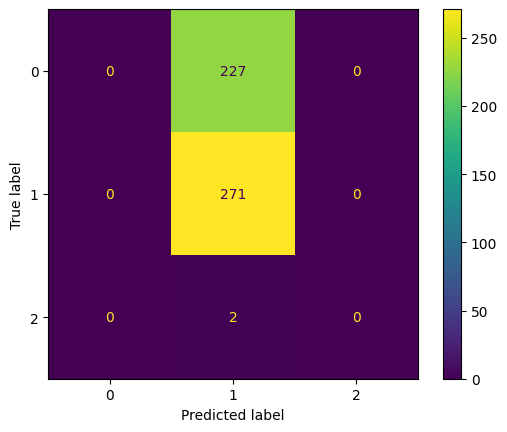


Class 2:


c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


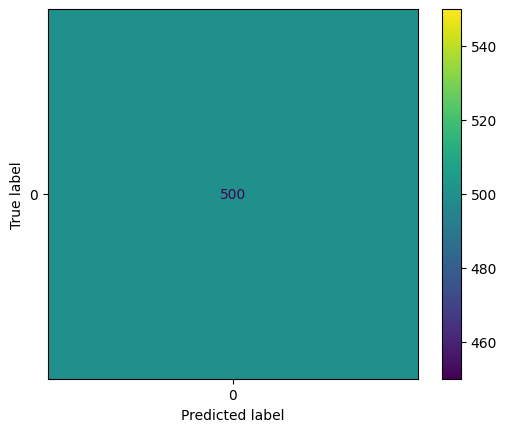


Class 3:


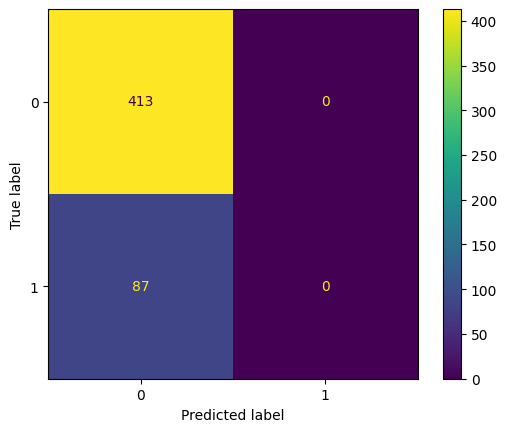


Class 4:


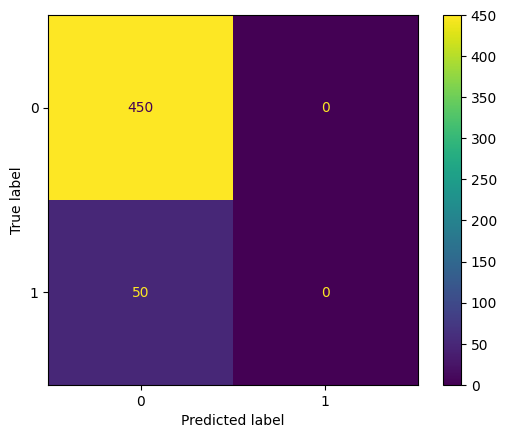


Class 5:


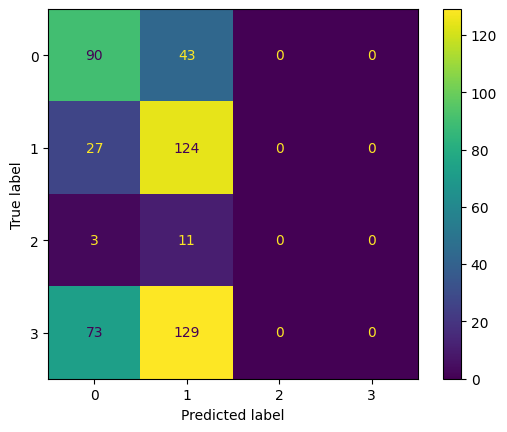


Class 6:


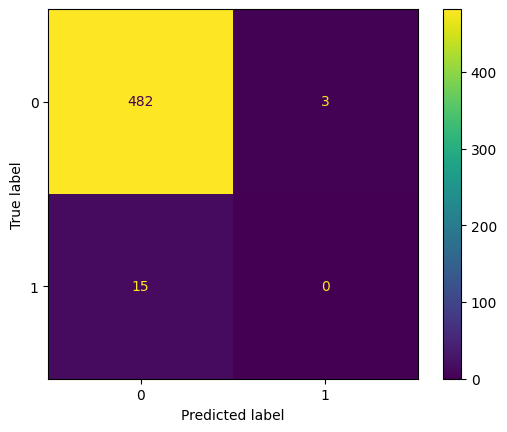


Class 7:


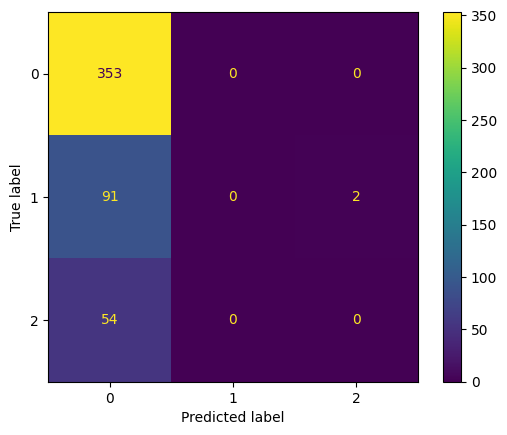


Class 8:


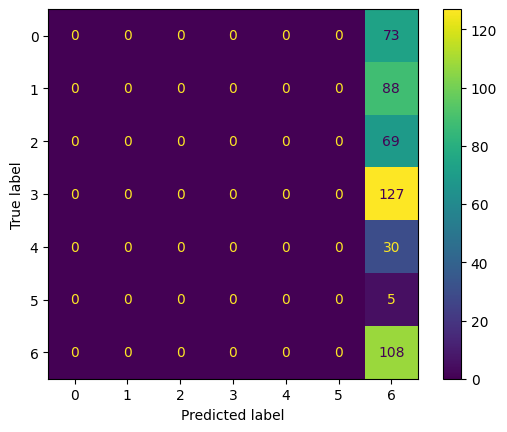


Class 9:


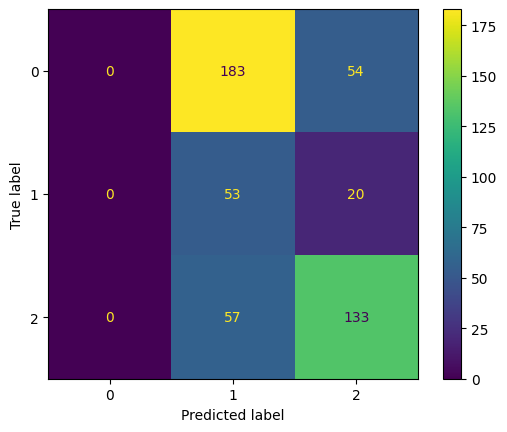


Class 10:


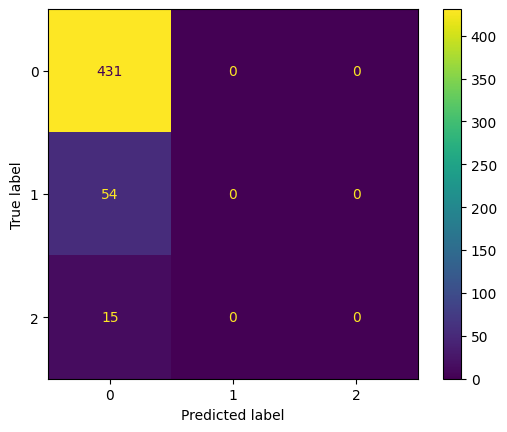


Class 11:


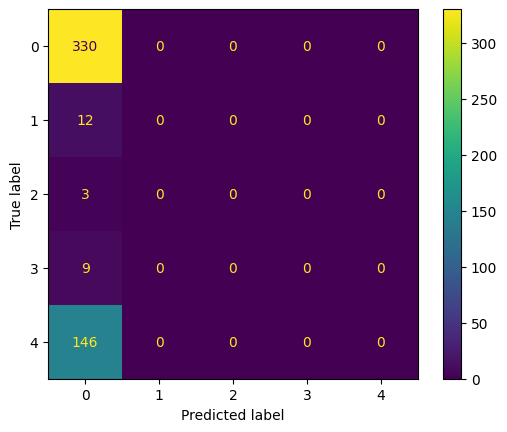

In [31]:
# Display confusion matrices in pretty format
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    cm = confusion_matrix(true_labels[i], pred_labels[i])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print()


In [32]:
# New model
if model_name is None:
    model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_{model.__class__.__name__}_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

In [3]:
# Save the model
if not os.path.exists(save_path):
    os.makedirs(save_path)
torch.save(model.state_dict(), save_path + model_name + ".pth")
print(f"Model saved as {model_name}")

NameError: name 'optimizer' is not defined

In [55]:
# # Load the model
# model = MultiHeadModel()
# model.load_state_dict(torch.load(save_path + model_name + ".pth", weights_only=True, map_location=DEVICE))


<All keys matched successfully>